In [93]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits

In [94]:
# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting
# in the current Notebook
%matplotlib inline

In [95]:
zeroes=os.listdir("20181018/Zeroes/")
mars=os.listdir("20181018/Mars/")
comps=os.listdir("20181018/comps/")
darks=os.listdir("20181018/Darks/")
BobRoss=os.listdir("BobRoss/")
marsNotGarbage=os.listdir("20181018/marsNotGarbage/")
bkgS=os.listdir("bkg/")
print(bkgS)

['bkg_Mars7Tilt2.FIT', 'bkg_Comp1Ar.FIT', 'bkg_Mars6.FIT', 'bkg_Mars4.FIT', 'bkg_Mars8Tilt2.FIT', 'bkg_Mars10Tilt3.FIT', 'bkg_d003.FIT', 'bkg_d002.FIT', 'bkg_Mars5.FIT', 'bkg_Mars1.FIT', 'bkg_Mars3.FIT', 'bkg_Mars9Tilt3.FIT', 'bkg_Comp2Ar.FIT', 'bkg_Mars2.FIT', 'bkg_d001.FIT']


In [96]:
print(zeroes,mars,comps,darks,marsNotGarbage)

['z004.FIT', 'z006.FIT', 'z002.FIT', 'z008.FIT', 'z009.FIT', 'z005.FIT', 'z003.FIT', 'z001.FIT', 'z007.FIT'] ['Mars5.FIT', 'Mars2.FIT', 'Mars9Tilt3.FIT', 'Mars4.FIT', 'Mars1.FIT', 'Mars3.FIT', 'Mars6.FIT', 'Mars7Tilt2.FIT', 'Mars10Tilt3.FIT', 'Mars8Tilt2.FIT'] ['Comp1Ar.FIT', 'Comp2Ar.FIT', 'Comp2neon.FIT'] ['d001.FIT', 'd003.FIT', 'd002.FIT'] ['Mars2.FIT', 'Mars9Tilt3.FIT', 'Mars4.FIT', 'Mars1.FIT', 'Mars10Tilt3.FIT']


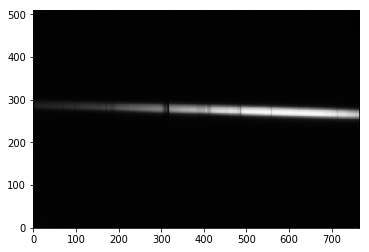

In [97]:
test=fits.open('20181018/Mars/Mars9Tilt3.FIT')[0].data.astype(np.float) 
plt.imshow(test)

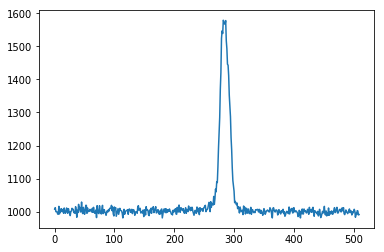

In [98]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(test[:,100])

## Bias correction

In [99]:
nrow,ncol=np.shape(fits.open('20181018/Zeroes/z001.FIT')[0].data.astype(np.float))

alldata=np.ones((len(zeroes),nrow,ncol))

for i in range (0,len(zeroes)):
    sci_fn = '20181018/Zeroes/'+zeroes[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

masterbias= np.median(alldata,axis=0)

In [100]:
masterbias

array([[994., 985., 990., ..., 965., 962., 966.],
       [987., 992., 991., ..., 963., 969., 968.],
       [989., 988., 988., ..., 970., 970., 970.],
       ...,
       [986., 989., 988., ..., 964., 971., 965.],
       [984., 988., 985., ..., 964., 967., 974.],
       [993., 993., 986., ..., 971., 968., 973.]])

In [101]:
def unbias(file,directory='Mars/'):
    sci_fn = "20181018/"+directory+file
    out= "CNN/"+file
    sci_hdulist = fits.open(sci_fn)
    biased = sci_hdulist[0].data.astype(np.float)
    biascor= biased-masterbias
    hdu = fits.PrimaryHDU(biascor)
    hdu.writeto(out, overwrite=True)

In [102]:
##'Pythonic' method to unbias all mars spectra
[unbias(file) for file in mars]
[unbias(file,'Darks/') for file in darks]
[unbias(file, 'comps/') for file in comps]

[None, None, None]

## Dark Correction

In [103]:
nrow,ncol=np.shape(fits.open('CNN/d001.FIT')[0].data.astype(np.float))
alldata=np.ones((len(darks),nrow,ncol))

for i in range (0,len(darks)):
    sci_fn = 'CNN/'+darks[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

masterdark= np.median(alldata,axis=0)

In [104]:
def lightenUp(file,directory='CNN/'):
    sci_fn = directory+file
    out= "BobRoss/"+file
    sci_hdulist = fits.open(sci_fn)
    darkened = sci_hdulist[0].data.astype(np.float)
    undarkened= darkened-masterdark
    hdu = fits.PrimaryHDU(undarkened)
    hdu.writeto(out, overwrite=True)

In [105]:
##'Pythonic' method to unbias all mars spectra
[lightenUp(file) for file in mars]
[lightenUp(file) for file in comps]

[None, None, None]

## Sky Background

In [106]:
sci_fn="BobRoss/Mars1.FIT"
sci_hdulist = fits.open(sci_fn)
spec = sci_hdulist[0].data.astype(np.float)

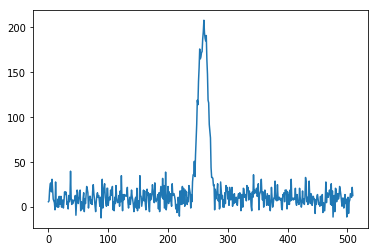

In [107]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(spec[:,382])

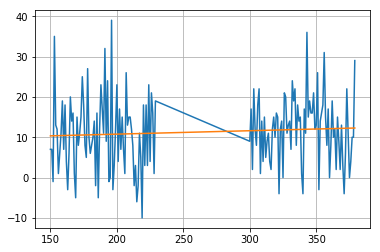

In [108]:
y=np.append(np.arange(150,230),np.arange(300,380))
x=spec[y,382]
plt.figure()
plt.plot(y, x)
pfit = np.polyfit(y, x, 1)  # Fit a 1st order polynomial to (x, y) data
xfit = np.polyval(pfit, y)  # Evaluate the polynomial at x
plt.plot(y, xfit)
plt.grid()

In [109]:
print(np.mean(x))
print(np.mean(spec))

11.3125
23.463360246059207


In [110]:
ycols = np.arange(spec.shape[0])            # Array from 0 .. N_rows-1
bkg = np.zeros_like(spec)                   # Empty image for background fits
for row in np.arange(spec.shape[1]):        # For each row ...
    pfit = np.polyfit(y, spec[y,row], 1)    # Fit poly over bkg col for row
    bkg[:,row] = np.polyval(pfit, ycols)    # Eval poly at ALL row positions

In [111]:
spec.shape[1]

765

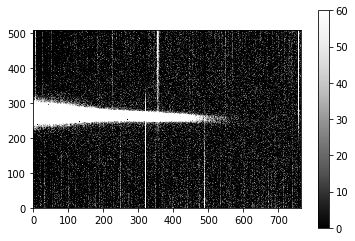

In [112]:
spec_bkg = spec - bkg
plt.clf()
plt.imshow(spec_bkg, origin = 'lower', vmin=0, vmax=60)
plt.colorbar()

In [113]:
y=np.append(np.arange(150,230),np.arange(300,380))
def unbg(file,directory='Mars/'):
    sci_fn = 'BobRoss/'+file
    out= "bkg/bkg_"+file
    flatspec = fits.open(sci_fn)[0].data.astype(np.float)
    x = flatspec[y, 382]  
    pfit = np.polyfit(y,x, 1)  
    ycols = np.arange(flatspec.shape[0])            # Array from 0 .. N_rows-1
    bkg = np.zeros_like(flatspec)                   # Empty image for background fits
    for row in np.arange(flatspec.shape[1]):        # For each row ...
       pfit = np.polyfit(y, flatspec[y,row], 1)     # Fit poly over bkg col for row
       bkg[:,row] = np.polyval(pfit, ycols)         # Eval poly at ALL row positions
    bkgsub=flatspec-bkg
    hdu = fits.PrimaryHDU(bkgsub)
    hdu.writeto(out, overwrite=True)

In [114]:
[unbg(file) for file in os.listdir('BobRoss')]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [115]:
#flatspec.shape[1]

In [116]:
BobRoss

['Mars5.FIT',
 'Mars2.FIT',
 'Mars9Tilt3.FIT',
 'Mars4.FIT',
 'Mars1.FIT',
 'Mars3.FIT',
 'Mars6.FIT',
 'Comp1Ar.FIT',
 'Mars7Tilt2.FIT',
 'Mars10Tilt3.FIT',
 'Comp2Ar.FIT',
 'Mars8Tilt2.FIT']

### Spectrum extraction
Now we're ready to extract the 1D spectra from the background-subtracted frame, and then to extract the calibration lamp spectra the same way. Let's first inspect a plot of one of these background-subtracted frames across line 512:

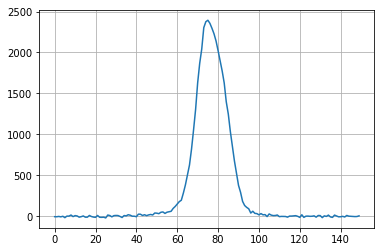

In [117]:
sci_fn="bkg/bkg_Mars9Tilt3.FIT"
sci_hdulist = fits.open(sci_fn)
spec = sci_hdulist[0].data.astype(np.float)
plt.figure()  

plt.plot(spec[200:350,382])  #This is the last frame from the loop above
plt.grid()

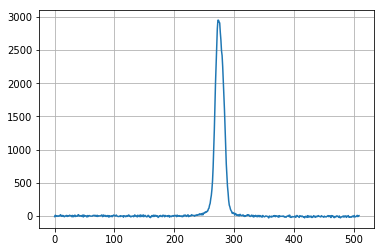

In [118]:
plt.figure()
plt.plot(spec[:,420])
plt.grid()

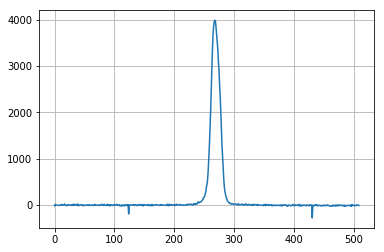

In [119]:
plt.figure()
plt.plot(spec[:, 633])
plt.grid()

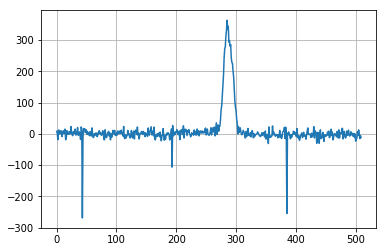

In [120]:
plt.figure()
plt.plot(spec[:,1])
plt.grid()

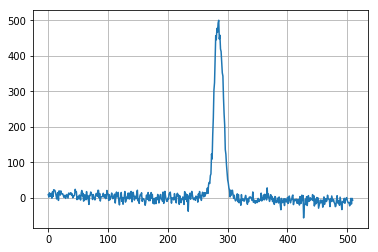

In [121]:
plt.figure()
plt.plot(spec[:,69])
plt.grid()

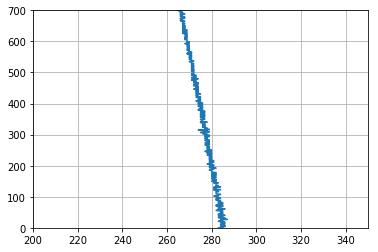

In [122]:
specrow=np.argmax(spec,axis=0)
y=np.arange(0, len(spec[275, :]))
plt.figure()
plt.xlim(200,350)
plt.ylim(0,700)
plt.plot(specrow,y)
plt.grid()

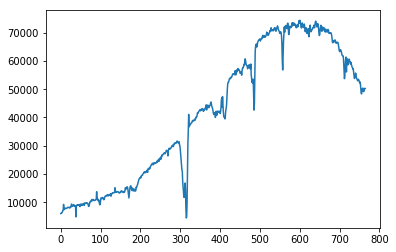

In [123]:
ext_spec = spec[250:350,:].sum(axis=0)
#print(ext_spec)
plt.figure()   
plt.plot(ext_spec) 

In [124]:
ext_spec=np.zeros((len(bkg),765))

for i in range (0,len(bkgS)):
    sci_fn = "bkg/"+bkgS[i]
    sci_hdulist = fits.open(sci_fn)
    bkgspec = sci_hdulist[0].data.astype(np.float)
    ext_spec[i,:] = bkgspec[250:350,:].sum(axis=0)

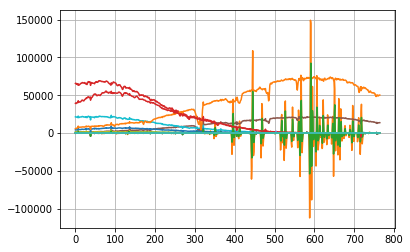

In [125]:
plt.figure()
[plt.plot(f) for f in ext_spec]
#plt.plot(ext_spec[13])
plt.grid()

We now have reduced, extracted spectra in arrays labeled ext_spec[0], ext_spec[1], etc.

### Dispersion solution
We are now ready to find the dispersion solution and apply it. To do this, we must use the calibration lamp spectrum and identify as many lines as we can. In most cases, you want to use calibration lamp spectra taken at the same telescope position as the object spectrum. This accounts for small wavelength shifts that can arise from flexture in the instrument as it as placed at different angles to point the telescope.

First, we'll extract the comparison spectra the same way we did the data spectra, and plot one of them.

In [154]:
ext_comp=[]
def makeComp(compa):
    comp_fn="BobRoss/"+compa
    comp_hdulist = fits.open(comp_fn)
    comp = comp_hdulist[0].data.astype(np.float)
    ext_comp.append(comp[250:350,:].sum(axis=0))

In [155]:
[makeComp(comp) for comp in comps]

[None, None, None]

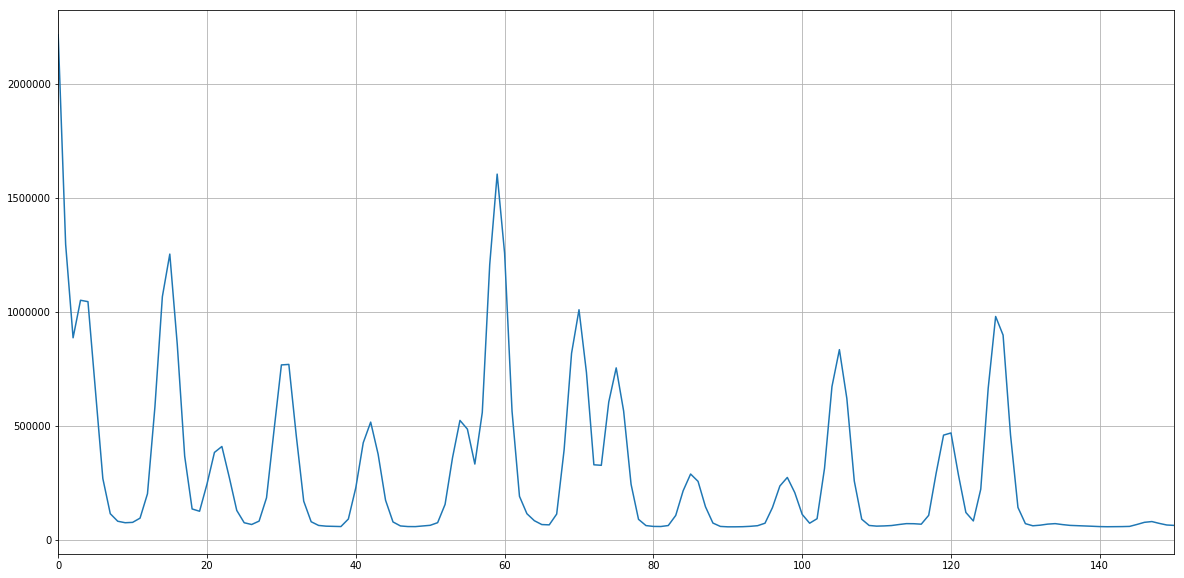

In [191]:
plt.figure(figsize=(20,10))  # Start a new plot -- by default matplotlib overplots.
plt.plot(ext_comp[2]) 
plt.xlim(0,150)
plt.grid()

Now, you need to identify several lines in the spectrum and associate them with rows on the CCD. You can do this by zooming in on the plot above- by uncommenting and adjusting the xlim command above. For example, the strong line at 4609.5673 A lies at pixel (row) 308.

It is ok to use half pixel values in cases where the line maximum spreads across 2 pixels.


**QUESTION** Complete the following tables:

| comp1.fits|         |
|------------|---------|
| wavelength | pixel   |
|------------|---------|      
|  6402.25   |   0
|------------|---------|
|  6382.99   |  3.5    |
|------------|---------|
|  6334.43   |  15     |
|------------|---------|
|  6304.79   |  22     |
|------------|---------|
|  6266.49   |  30.5   |
|------------|---------|
|  6217.28   |  42     |
|------------|---------|
|  6163.59   |  54.5   |
|------------|---------|
|  6143.06   |  59     |
|------------|---------|
|  6096.16   |  70     |
|------------|---------|
|  6074.34   |  75     |
|------------|---------|
|  6030.00   |  85     |
|------------|---------|
|  5975.53   |  98     |
|------------|---------|  
|  5944.83   |  105    |
|------------|---------| 
|  5881.89   |  119.5  |
|------------|---------|
|  5852.49   |  126    |
|------------|---------|

In [192]:
x=[0,3.5,15,22,30.5,42,54.5,59,70,75,85,98,105,119.5,126]
y=[6402.25,6382.99,6334.43,6304.79,6266.49,6217.28,6163.59,6143.06,6096.16,6074.34,6030.00,5975.53,5944.83,5881.89,5852.49]
#x1=[590,566,606]
#x2=[589,566]
#y1=[750,746.5,761]
#y2=[750,746.5]

In [193]:
# pfit1 = np.polyfit(x1, y1, 1)  # Fit a 1st order polynomial to (x1, y) data
# yfit1 = np.polyval(pfit1, x1)  # Evaluate the polynomial at x1
# plt.plot(x1, yfit1)
# plt.scatter(x1,y1)
# plt.grid()
# print(pfit1)

In [194]:
# pfit2 = np.polyfit(x2, y2, 1)  # Fit a 1st order polynomial to (x1, y) data
# yfit2 = np.polyval(pfit2, x2)  # Evaluate the polynomial at x1
# plt.plot(x2, yfit2)
# plt.scatter(x2,y2)
# plt.grid()

(510, 765)

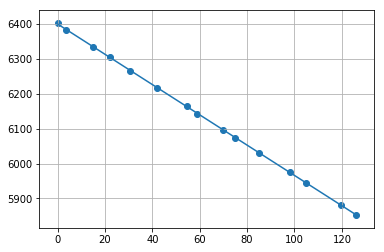

In [195]:
pfit = np.polyfit(x, y, 1)  # Fit a 1st order polynomial to (x1, y) data
yfit = np.polyval(pfit, x)  # Evaluate the polynomial at x1
plt.plot(x, yfit)
plt.scatter(x,y)
plt.grid()
ext_spec.shape

In [134]:
# wavefit=[0]*765
# print(ext_spec[1,:].shape)
# for i in range(len(wavefit)):
#     plt.figure()
#     xrow=np.arange(0, 765)
#     wavefit[i]=np.polyval(pfit, xrow)
#     plt.plot(wavefit[i],ext_spec[i,:])
#     plt.grid()

In [138]:
# for i in range(0,510):
#     col1 = fits.Column(name='Wavelength', format='E', array=wavefit[i])
#     col2 = fits.Column(name='Flux', format='E', array=ext_spec[i])
#     cols = fits.ColDefs([col1, col2])
#     tbhdu = fits.BinTableHDU.from_columns(cols)
#     tbhdu.writeto('final/spec'+str(i)+'.fits',overwrite=True)

# Wavelength conversion

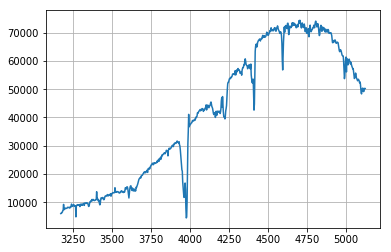

In [139]:
#spec[1,:]
pancakes=np.polyval(pfit,np.arange(1,766))
#pancakes.size
#spec.shape
#for i in range(len(pancakes)):
 #   print(pancakes[i],spec[250:350,:].sum(axis=0)[i])
#print(pancakes)
plt.plot(pancakes,spec[250:350,:].sum(axis=0))
plt.grid()
##Angstroms

Mars5.FIT
Mars2.FIT
Mars9Tilt3.FIT
Mars4.FIT
Mars1.FIT
Mars3.FIT
Mars6.FIT
Mars7Tilt2.FIT
Mars10Tilt3.FIT
Mars8Tilt2.FIT


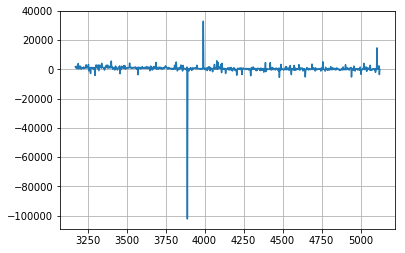

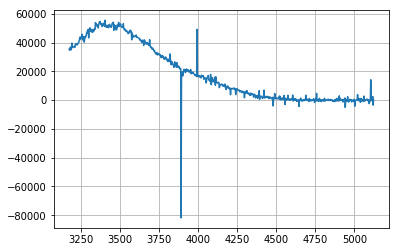

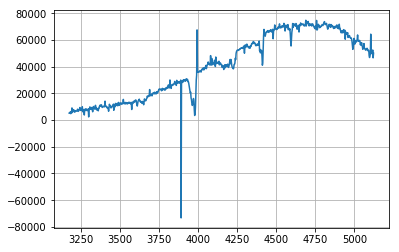

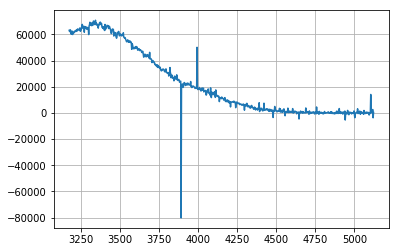

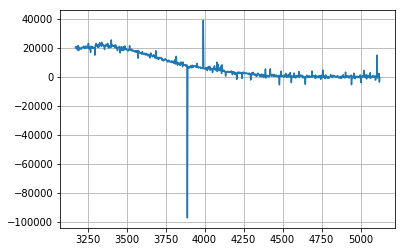

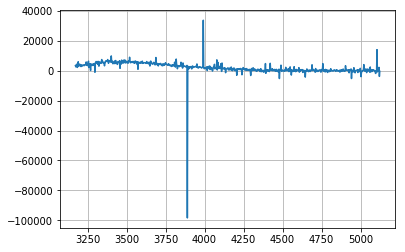

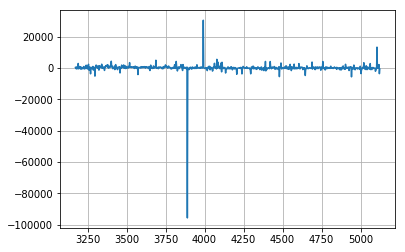

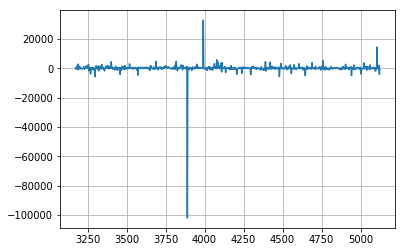

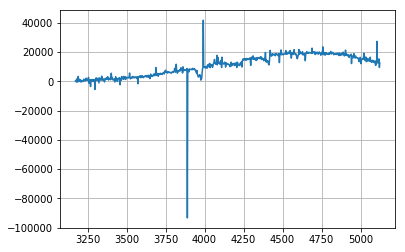

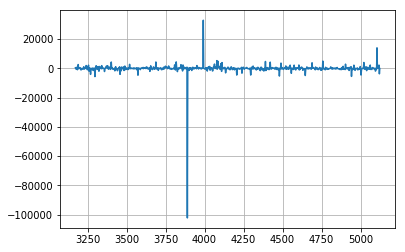

In [140]:
for file in mars:
    sci_fn="bkg/bkg_"+file
    sci_hdulist = fits.open(sci_fn)
    spec = sci_hdulist[0].data.astype(np.float)
    print(file)
    plt.figure()
    plt.plot(pancakes,spec[:,:].sum(axis=0))
    plt.grid()
    #plt.xlim(4580,4600)
    #Mars9Tilt3 3890, 4413, 4595

In [141]:
print(mars)

['Mars5.FIT', 'Mars2.FIT', 'Mars9Tilt3.FIT', 'Mars4.FIT', 'Mars1.FIT', 'Mars3.FIT', 'Mars6.FIT', 'Mars7Tilt2.FIT', 'Mars10Tilt3.FIT', 'Mars8Tilt2.FIT']


# SNR

In [142]:
img = fits.open("bkg/bkg_Mars9Tilt3.FIT")[0].data.astype(np.float)

In [143]:
Nstar=np.sum(img)

In [144]:
npix=len(img)*len(img[0])

In [145]:
ρb=(230-150+380-300)*len(img[0])

In [146]:
ab=1+npix/ρb

In [147]:
ab

4.1875

In [148]:
b=np.mean([np.mean(img[150:230]),np.mean(img[300:380])])

In [149]:
dark=fits.open('20181018/Darks/d001.FIT')[0].data.astype(np.float)
d=np.mean(dark)

In [150]:
ρ=4

In [151]:
print(Nstar,npix,ab,b,d,ρ)

30989360.237836443 390150 4.1875 5.88418203051333e-15 975.9857900807382 4


In [152]:
SNR=Nstar/(Nstar+npix*ab*(b+d)+npix*ab*ρ**2)**.5

In [153]:
SNR

762.524318772439